In [85]:
from PIL import Image
import imagehash
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import hamming
from collections import deque
from pprint import pprint
import skimage
import numpy as np
import cv2
import matplotlib
from scipy.ndimage import measurements


In [86]:
known_events = [15505, 23565, 38750]
known_events = [22628, 30966, 51000, 63620, 67260, 67550, 70083, 72170, 77220, 78356, 113190, 115600]
cap = cv2.VideoCapture('trashcam 2.avi')          

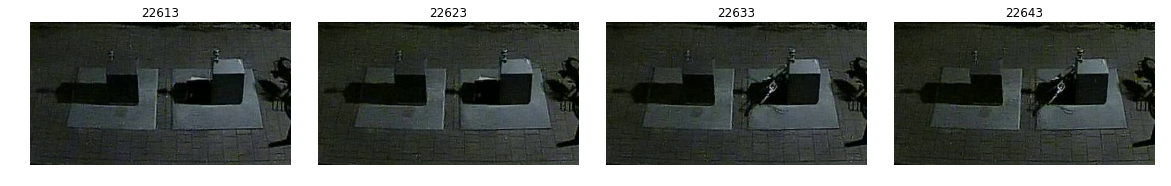

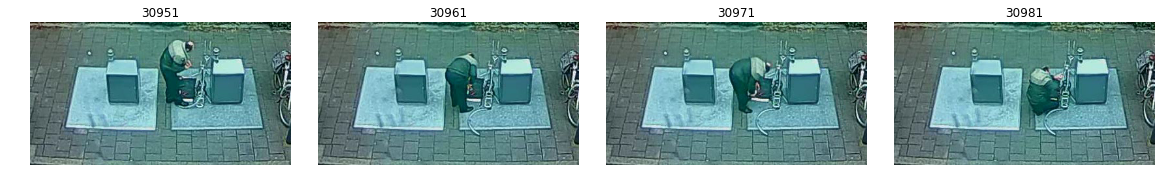

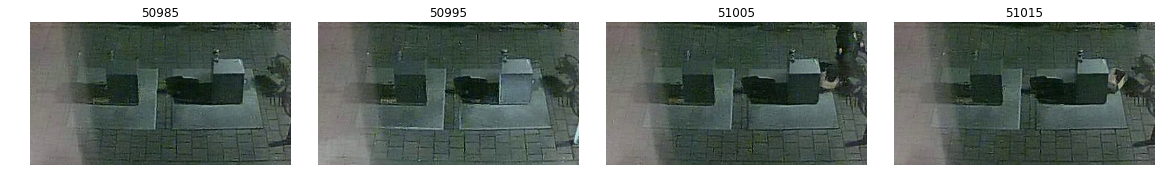

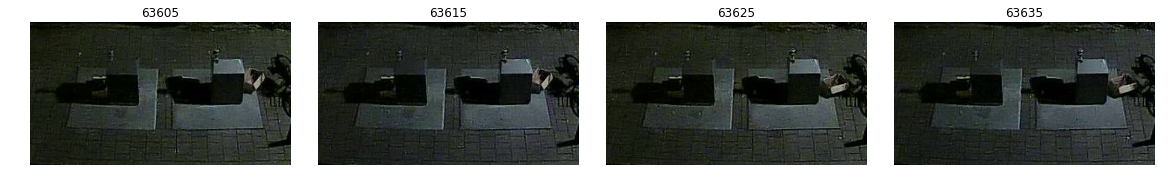

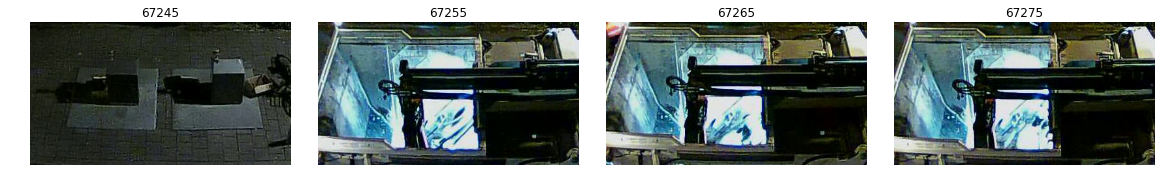

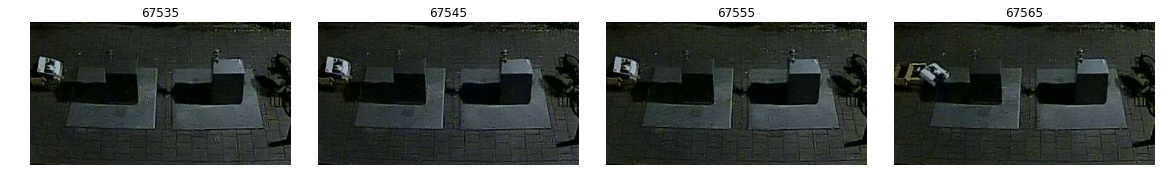

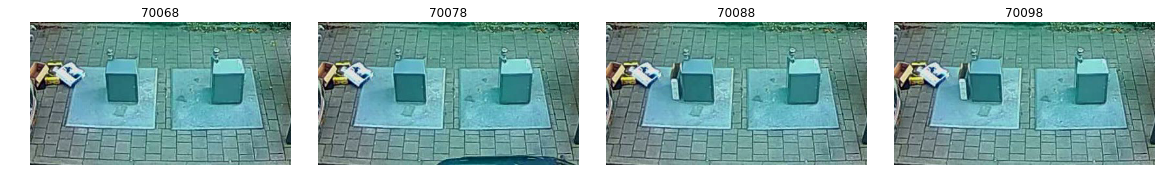

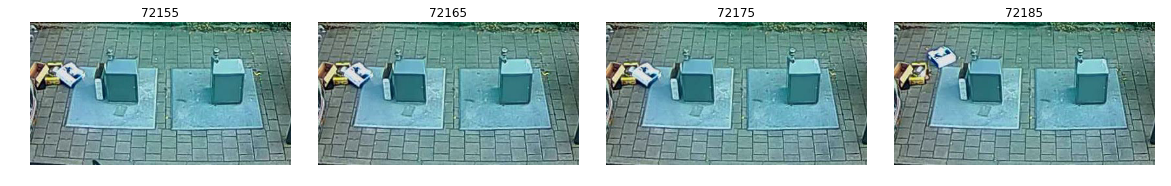

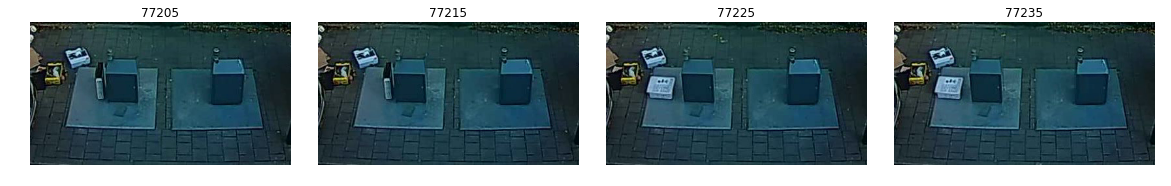

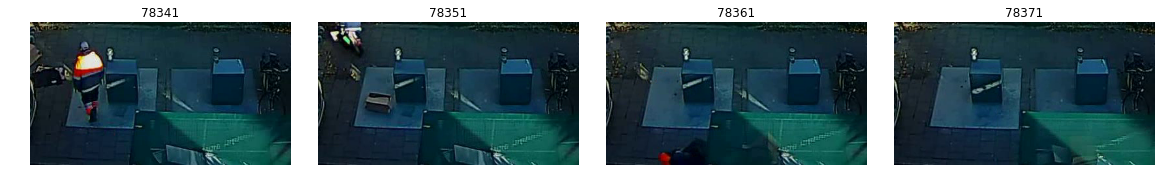

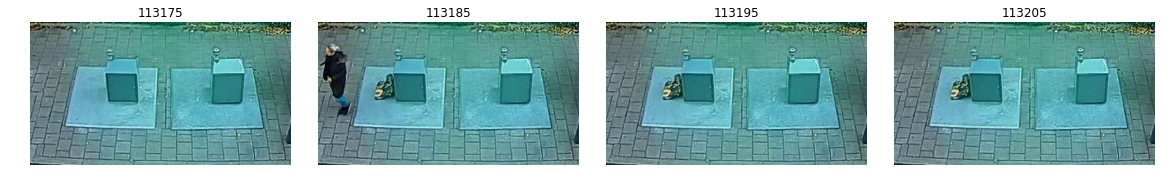

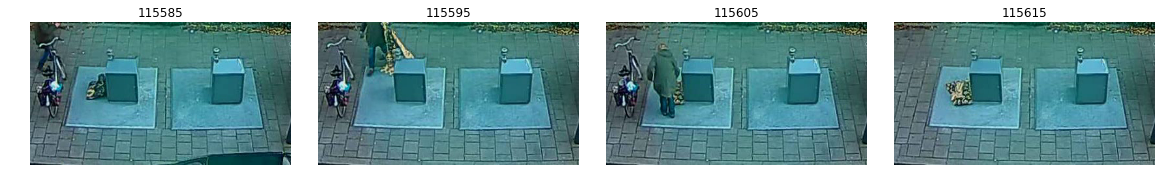

In [87]:
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (16.0, 3)
for fn in known_events:
    fig, ax = plt.subplots(nrows=1, ncols=4)
    fig.tight_layout(pad=0, w_pad=0, h_pad=0)
    for i in range(4):
        f = (fn - 15) + (10*i)
  
        cap.set(1,f)
        ret, frame = cap.read()
        ax[i].axis("off")
        ax[i].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        ax[i].set_title(str(f))
        ax[i].set_xmargin(0)
        ax[i].set_ymargin(0)

In [41]:
cap.set(1,0)
frame_shape = cap.read()[1].shape
buffer_len = 50
buffer = np.zeros((buffer_len,frame_shape[0],frame_shape[1],2), np.uint8)
indices = np.zeros(buffer_len,np.uint32)

In [42]:
def difference(img1, img2):
    #absolute difference uint8 matrices
    return(np.uint8(np.abs(np.int16(img1)-img2)))

In [43]:
def frames_provider():
    ret = True
    while ret:
        ret, frame = cap.read()
        yield cv2.cvtColor(frame, cv2.COLOR_BGR2LAB)[...,1:]
frames = frames_provider()

In [44]:
results = pd.DataFrame(columns=['biggest_area','threshold'])

for i, frame in enumerate(frames):
    if i<21000:
        continue
        
    k = i % buffer_len
    buffer[k] = frame
    indices[k] = i
    if i<buffer_len:
        continue

    if i<21000:
        continue
    if i>25000:
        break
        
    if i % 20==0:
        split = i - int(buffer_len/2)

        before = np.median(buffer[indices<split],axis=0)
        after = np.median(buffer[indices>split],axis=0)
        delta = np.mean(difference(before, after),axis=2).astype(np.uint8)

        th_value,th = cv2.threshold(delta,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        
        if th_value > 0:
            kernel = np.ones((3,3),np.uint8)
            eroded = cv2.morphologyEx(th,cv2.MORPH_OPEN,kernel, iterations = 3)
            lw, num = measurements.label(eroded)
            biggest_region = np.max(np.unique(lw[eroded>0],return_counts=True)[1])

            results.loc[i] = (biggest_region, th_value)
        
    if i % 1000 == 0:
         print(i)

21000 2
22000 2
23000 2
24000 2
25000 2


In [45]:
results

biggest_area  threshold
21000       22057.0      127.0
21020       67064.0      126.0
21040         655.0        1.0
21100       20356.0        2.0
21120        3948.0        1.0
21140       36235.0        2.0

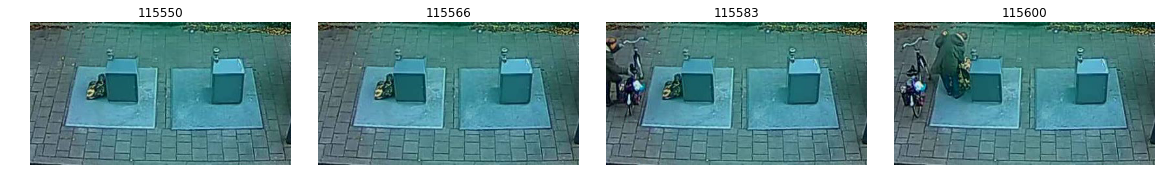

In [83]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (16.0, 3)
for fn in range(115600,123900,11440):
    fig, ax = plt.subplots(nrows=1, ncols=4)
    fig.tight_layout(pad=0, w_pad=0, h_pad=0)
    for i in range(4):
        f = fn-buffer_len + int(i/3*buffer_len)
  
        cap.set(1,f)
        ret, frame = cap.read()
        ax[i].axis("off")
        ax[i].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        ax[i].set_title(str(f))
        ax[i].set_xmargin(0)
        ax[i].set_ymargin(0)